In [2]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.colors

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook

import seaborn as sns
import time

from IPython.display import HTML
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [3]:
torch.manual_seed(0) #random numbers central point set
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

### Generate dataset

In [4]:
data , labels = make_blobs(n_samples=1000,centers=4,n_features=2,random_state=0) # 4 cluster classify , 2 feature
print(data.shape , labels.shape)

(1000, 2) (1000,)


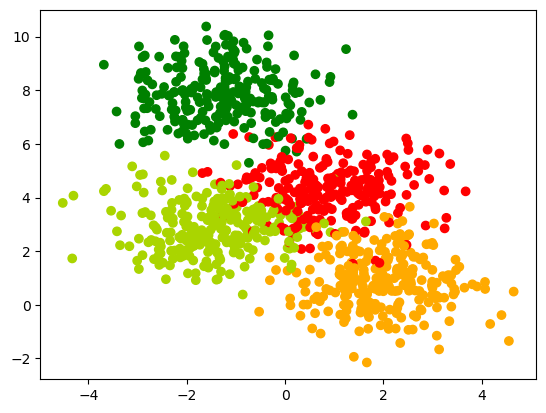

In [5]:
plt.scatter(data[:,0],data[:,1],c = labels,cmap=my_cmap)
plt.show()

In [6]:
x_train , x_test , y_train , y_test = train_test_split(data,labels,stratify=labels,random_state=0)
print(x_train.shape , x_test.shape,labels.shape)

(750, 2) (250, 2) (1000,)


### Using torch tensora and autograd 

In [7]:
x_train , x_test , y_train , y_test = map(torch.tensor,(x_train , x_test , y_train , y_test)) # xtrain change to torch tensor formate
print(x_train.shape , x_test.shape,labels.shape)

torch.Size([750, 2]) torch.Size([250, 2]) (1000,)


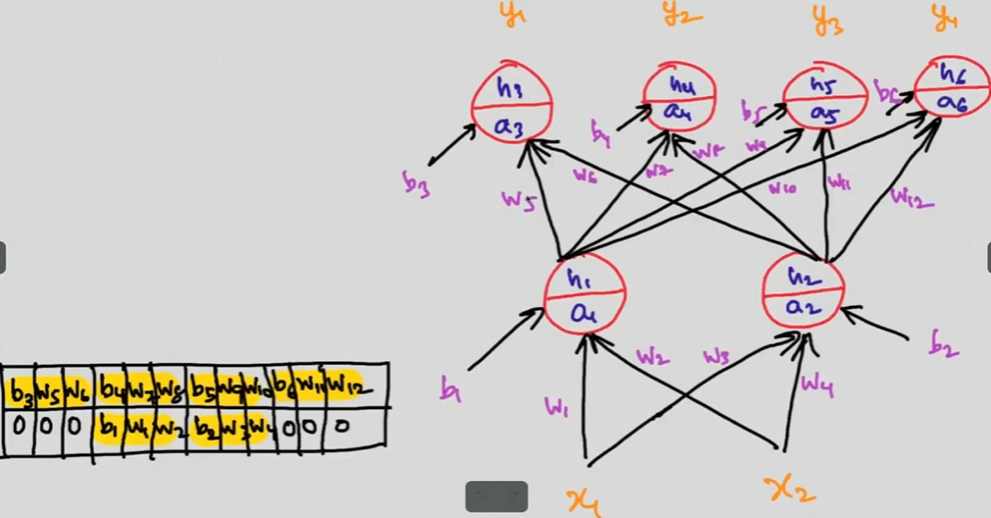

In [8]:
def model(x):
  a1 = torch.matmul(x, weights1) + bias1 # (N, 2) x (2, 2) -> (N, 2) - daimension

  h1 = a1.sigmoid() # (N, 2)
  a2 = torch.matmul(h1, weights2) + bias2 # (N, 2) x (2, 4) -> (N, 4) , 4 inputs

  h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # (N, 4) , exponensial sum - soft max

  return h2 # 4 inputs probability distribution


In [9]:
def loss_fn(y_hat,y):
    return -(y_hat[range(y.shape[0]),y].log()).mean() # crossenrtopy loss function -log

In [10]:
def accuracy(y_hat,y):
    pred = torch.argmax(y_hat,dim=1)
    return (pred == y).float().mean()


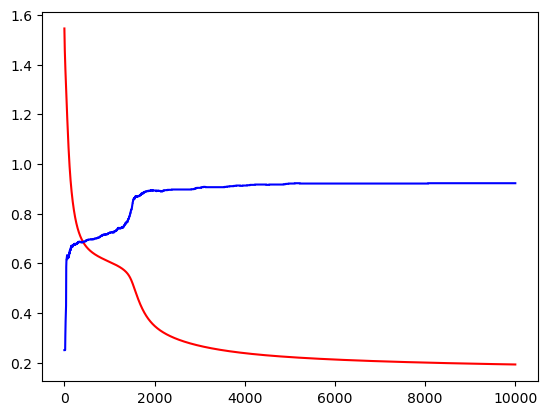

Loss before training 1.5456440448760986
Loss after training 0.19288595020771027


In [11]:
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000


x_train = x_train.float() # float convertr
y_train = y_train.long() # convert loss function basis index

loss_arr = [] # list initialise loss accuracy
acc_arr = []

for epoch in range(epochs):
    y_hat = model(x_train)

    loss = loss_fn(y_hat, y_train)
    loss.backward() # loss back ward propagation

    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, y_train)) # ploting purpose data save


    with torch.no_grad(): # w b update area no part of grad , not part of forward 
      weights1 -= weights1.grad * learning_rate
      bias1 -= bias1.grad * learning_rate
      weights2 -= weights2.grad * learning_rate
      bias2 -= bias2.grad * learning_rate

      weights1.grad.zero_()
      bias1.grad.zero_()
      weights2.grad.zero_()
      bias2.grad.zero_()
    
plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b')

plt.show()

print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])
    

## Using nn Functional

In [12]:
import torch.nn.functional as F

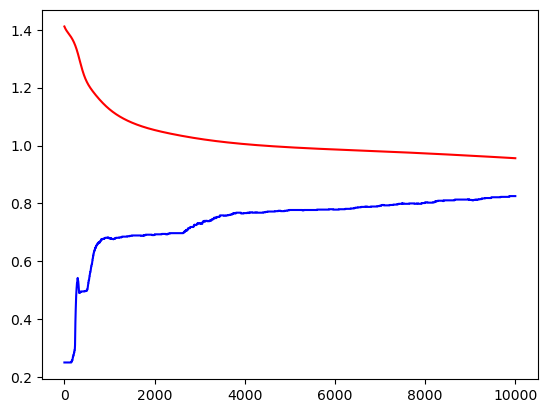

Loss before training 1.4111982583999634
Loss after training 0.9561847448348999


In [13]:
torch.manual_seed(0)

weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

loss_arr = []
acc_arr = []

for epoch in range(epochs):
    y_hat = model(x_train)  # Assuming 'model' is defined

    loss = F.cross_entropy(y_hat, y_train)  # Use F.cross_entropy , nn functional no use above loss functional , loss = loss_fn(y_hat, y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, y_train)) # ploting purpose data save


    with torch.no_grad(): # w b update area no part of grad , not part of forward 
      weights1 -= weights1.grad * learning_rate
      bias1 -= bias1.grad * learning_rate
      weights2 -= weights2.grad * learning_rate
      bias2 -= bias2.grad * learning_rate

      weights1.grad.zero_()
      bias1.grad.zero_()
      weights2.grad.zero_()
      bias2.grad.zero_()
    
plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b')

plt.show()

print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])               # loss decrease and accuracy increase

## Using NN.Parameter

In [14]:
import torch.nn as nn

class FirstNetwork(nn.Module):
    def __init__(self):
        super().__init__() # parent class initilisation
        torch.manual_seed(0)

        self.weights1 = nn.Parameter(torch.randn(2, 2) / math.sqrt(2))
        self.bias1 = nn.Parameter(torch.zeros(2))

        self.weights2 = nn.Parameter(torch.randn(2, 4) / math.sqrt(2))
        self.bias2 = nn.Parameter(torch.zeros(4))

    def forward(self, X):
        a1 = torch.matmul(X, self.weights1) + self.bias1
        h1 = a1.sigmoid()  # or torch.sigmoid(a1)
        a2 = torch.matmul(h1, self.weights2) + self.bias2
        h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1)  # Softmax
        return h2

In [15]:
def fit(epochs=1000, learning_rate=1):
    loss_arr = []
    acc_arr = []

    for epoch in range(epochs):
        y_hat = fn(x_train)

        loss = F.cross_entropy(y_hat, y_train)
        loss_arr.append(loss.item())

        acc = accuracy(y_hat, y_train)  # Assuming 'accuracy' function is defined
        acc_arr.append(acc)

        loss.backward()

        with torch.no_grad():
            for param in fn.parameters(): # fn class object fn , this code complete update w1,w2,b1,b2           code become short use para
                param -= learning_rate * param.grad  # Corrected: -= for subtraction

            fn.zero_grad()  # Zero gradients after update

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()

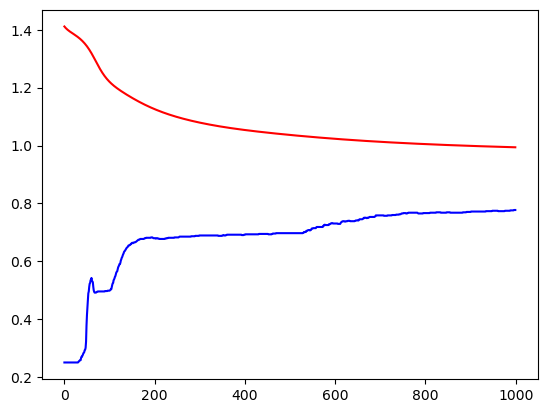

In [16]:
fn = FirstNetwork()
fit()

### nn.Linear

In [19]:
import torch.nn as nn

In [20]:
class FirstNetwork_v1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(2, 2) # ist leyer 2 input and 2 output ,weight initialise replace structure difine  using linear
        self.lin2 = nn.Linear(2, 4) # 2 input 4 output

    def forward(self, X):
        a1 = self.lin1(X) # 1st leyer input , automatic multiply and sum
        h1 = a1.sigmoid()  # or torch.sigmoid(a1) , 1st leyer output , 
        a2 = self.lin2(h1) # 2nd leyer input 
        h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1)  # Softmax ,2nd leyer output ,softmax -  each nuron expo 
        return h2

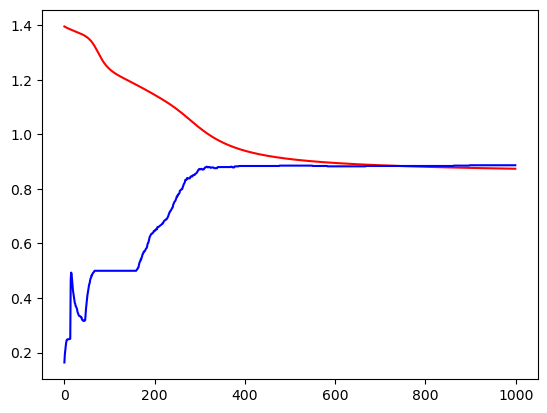

In [21]:
fn = FirstNetwork_v1() # same fit function
fit()

### NN.Optim

In [22]:
from torch import optim

In [28]:
def fit_v1( epochs=1000, learning_rate=1):
    loss_arr = []
    acc_arr = []

    opt = optim.SGD(fn.parameters(),learning_rate)  # Define optimizer , all parameter

    for epoch in range(epochs):
        y_hat = fn(x_train)

        loss = F.cross_entropy(y_hat, y_train)
        loss_arr.append(loss.item())

        acc = accuracy(y_hat, y_train)  # Assuming 'accuracy' function is defined
        acc_arr.append(acc)

        loss.backward()
        opt.step()           # Use optimizer to update weights , all parameter update
        opt.zero_grad()      # Zero gradients after update

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()

print('Loss before training', loss_arr[0])  # Access loss_arr after fit_v1()
print('Loss after training', loss_arr[-1])

Loss before training 1.4111982583999634
Loss after training 0.9561847448348999


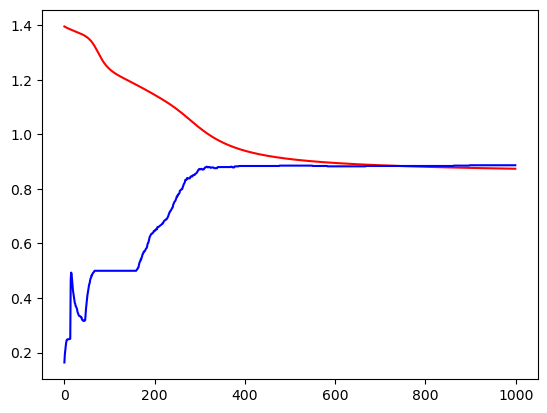

In [29]:
fn = FirstNetwork_v1() # same fit function
fit()